In [39]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xml.dom.minidom import parse, parseString

In [2]:
# read files 
stations = pd.read_json('stations.json.gz', lines=True)
# avg_tmax col in the weather data is °C×10, divide by 10
stations['avg_tmax'] = stations['avg_tmax'] / 10

city_data = pd.read_csv('city_data.csv')
# many cities has missing values, drop na_vals
city_data = city_data.dropna().reset_index()
# city area is given in m², convert to km²
#exclude cities with area greater than 10000 km².
city_data['area'] = city_data['area'] / 1000000
city_data = city_data[city_data['area'] < 10000]

In [3]:
stations

,observations,avg_tmax,station,latitude,longitude,elevation
0,300,10.201667,CA001092970,54.4500,-124.2833,691.0
1,320,13.930937,CA003030529,50.0333,-113.2167,967.0
2,273,12.355311,CA004038116,49.0000,-108.3833,902.0
3,220,14.597727,CA007016840,46.5833,-72.2333,16.0
4,326,21.910429,USC00033466,34.5128,-93.0486,190.8
...,...,...,...,...,...,...
9414,366,15.477049,USW00024130,44.8428,-117.8086,1024.4
9415,366,15.690164,USW00054756,42.5700,-72.2911,169.2
9416,366,15.534699,USW00054791,43.2781,-70.9222,98.5
9417,352,18.325852,USW00093786,38.3083,-75.1239,3.7


In [4]:
city_data.iloc[1]

index                6
name          Edmonton
population    812201.0
area            684.37
latitude          53.5
longitude       -113.5
Name: 1, dtype: object

In [5]:
# functions 'deg2rad' & 'distance' referenced from https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula/21623206
def deg2rad(deg) :
  return deg * (math.pi/180)

#  write a function that calculates the distance between one city and every station
def distance(city, stations):
    R = 6371
    data = stations 
    data.loc[:, 'cname'] = city['name']
    data.loc[:, 'cpd'] = city['population']
    data.loc[:, 'clat'] = city['latitude']
    data.loc[:, 'clon'] = city['longitude']
    
    data['dLat'] = deg2rad((data['clat']-data['latitude']))
    data['dLon'] = deg2rad((data['clon']-data['longitude']))

    data['a'] = np.sin(data['dLat']/2) * np.sin(data['dLat']/2) + np.cos(deg2rad(data['latitude'])) * np.cos(deg2rad(data['clat'])) * np.sin(data['dLon']/2) * np.sin(data['dLon']/2)

    data['c'] = 2 * np.arctan2(np.sqrt(data['a']), np.sqrt(1-data['a']))

    data['d'] = R * data['c']
    
    return data


In [13]:
distance(city_data.iloc[1], stations)


,observations,avg_tmax,station,latitude,longitude,elevation,cname,cpd,clat,clon,dLat,dLon,a,c,d
0,300,10.201667,CA001092970,54.4500,-124.2833,691.0,Edmonton,812201.0,53.5,-113.5,-0.016581,0.188204,0.003122,0.111811,712.346719
1,320,13.930937,CA003030529,50.0333,-113.2167,967.0,Edmonton,812201.0,53.5,-113.5,0.060505,-0.004945,0.000917,0.060583,385.971235
2,273,12.355311,CA004038116,49.0000,-108.3833,902.0,Edmonton,812201.0,53.5,-113.5,0.078540,-0.089303,0.002319,0.096346,613.822834
3,220,14.597727,CA007016840,46.5833,-72.2333,16.0,Edmonton,812201.0,53.5,-113.5,0.120719,-0.720240,0.054405,0.470833,2999.679622
4,326,21.910429,USC00033466,34.5128,-93.0486,190.8,Edmonton,812201.0,53.5,-113.5,0.331389,-0.356944,0.042651,0.416037,2650.573328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9414,366,15.477049,USW00024130,44.8428,-117.8086,1024.4,Edmonton,812201.0,53.5,-113.5,0.151097,0.075199,0.006293,0.158820,1011.839222
9415,366,15.690164,USW00054756,42.5700,-72.2911,169.2,Edmonton,812201.0,53.5,-113.5,0.190764,-0.719231,0.063321,0.508742,3241.193301
9416,366,15.534699,USW00054791,43.2781,-70.9222,98.5,Edmonton,812201.0,53.5,-113.5,0.178406,-0.743123,0.065021,0.515680,3285.394781
9417,352,18.325852,USW00093786,38.3083,-75.1239,3.7,Edmonton,812201.0,53.5,-113.5,0.265145,-0.669789,0.067893,0.527209,3358.851627


In [21]:
# write a function that returns the best value you can find for 'avg_tmax' (& population density) for that one city
def best_tmax(city, stations):
    data = distance(city, stations)
    index = np.argmin(data['d'])
    
    return data.loc[index][['avg_tmax', 'cpd']]

In [22]:
best_tmax(city_data.iloc[1], stations)

avg_tmax    11.098338
cpd          812201.0
Name: 2145, dtype: object

In [ ]:
# apply function across all cities
#city_data.apply(best_tmax, stations=stations)

In [35]:
# !!couldn't make aplly function to work, so using for loop
pop = []
temp = []
for i in range(len(city_data)):
    t, p = best_tmax(city_data.iloc[i], stations)
    pop.append(p)
    temp.append(t)

In [36]:
pop, temp

([1096833.0,
  812201.0,
  133497.0,
  223218.0,
  83811.0,
  7139.0,
  198309.0,
  468251.0,
  603502.0,
  80032.0,
  56224.0,
  106172.0,
  6699.0,
  141434.0,
  175779.0,
  161531.0,
  519949.0,
  219153.0,
  301709.0,
  713443.0,
  883391.0,
  43086.0,
  75141.0,
  108359.0,
  2731571.0,
  12823.0,
  313.0,
  4189.0,
  5913.0,
  666.0,
  276245.0,
  20484.0,
  7282.0,
  5654.0,
  22429.0,
  13657.0,
  2751.0,
  3377.0,
  46692.0,
  1704694.0,
  9273.0,
  531902.0,
  84285.0,
  49197.0,
  42334.0,
  145949.0,
  2640.0,
  25686.0,
  111575.0,
  32491.0,
  7716.0,
  193100.0,
  222189.0,
  23276.0,
  8550406.0,
  319198.0,
  2722389.0,
  2195914.0,
  1469471.0,
  1560297.0,
  1436697.0,
  1394928.0,
  1197816.0,
  1000536.0,
  912791.0,
  821784.0,
  852469.0,
  787033.0,
  853173.0,
  812238.0,
  731424.0,
  608660.0,
  682545.0,
  649133.0,
  672228.0,
  655884.0,
  680250.0,
  668347.0,
  646889.0,
  583776.0,
  579999.0,
  583756.0,
  760026.0,
  621849.0,
  600155.0,
  545852.0,


Text(0, 0.5, 'Population Density (people/km²)')

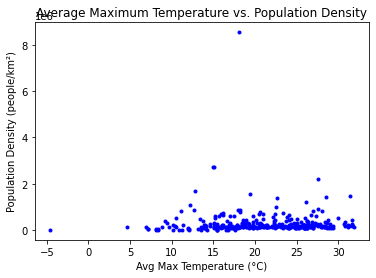

In [41]:
# plot scatterplot of average maximum temperature against population density 
# add title and label the axes
fig, ax = plt.subplots()
plt.plot(temp, pop, 'b.')
plt.title("Average Maximum Temperature vs. Population Density")
plt.xlabel('Avg Max Temperature (\u00b0C)')
plt.ylabel('Population Density (people/km\u00b2)')

In [ ]:
# save the image
fig.savefig(image_name, format=image_format, dpi=1200)